In [298]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from random import shuffle
import matplotlib.pyplot as plt

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [556]:
def gen_data_raw(user_info,pref_map, num_layouts, size=1000, var=10):
    average = 1
    high = 10
    data_x = []
    data_y = []
    for _ in range(size):
        for field, val, layout in pref_map:
            x = list(user_info.values())+[np.random.randint(num_layouts)]
            data_x.append(x)
            data_y += [average]
            
    for _ in range(size):
        for field, val, layout in pref_map:
            u = user_info.copy()
            u[field] = val 
            if not isinstance(val, str):
                u[field] += np.random.rand()*var - var/2
            x = list(u.values())+[layout]
            data_x.append(x)
            data_y += [high]
    
    zipped = list(zip(data_x,data_y))
    shuffle(zipped)
    data_x, data_y = zip(*zipped)
    
    return (data_x, data_y)

def is_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def data_clean(x):
    for a in range(len(x)):
        for b in range(len(x[a])):
            e = x[a][b]
            if isinstance(e, int):
                x[a][b] = float(e)
            elif isinstance(e, str):
                if e == '':
                    x[a][b]=0
                elif is_int(e[0]):
                    # date
                    x[a][b]=0
                else:
                    # browser categorical
                    if e == "Chrome":
                        x[a][b] = 0
                    else:
                        x[a][b] = 1
                    
            elif e == None:
                x[a][b] = 0
    return x

def data_normalize(x):
    average = np.sum(x,axis=0)/x.shape[0]
    for a in range(len(x)):
        for b in range(len(x[a])):
            x[a][b] = x[a][b]/(average[b]+0.0001) - 0.5
            
    return x

def gen_data(user_info,pref_map, num_layouts, size=1000, var=10):
    data_x, data_y = gen_data_raw(user_info,pref_map, num_layouts, size, var)

    data_x = data_clean(data_x)
    
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    
    data_x = data_normalize(data_x)
    
    return (data_x, data_y)

In [566]:
user_info = {'timeOpened': '2019-03-31T18:37:50.965Z', 'timezone': 4, 'longitude': -80.5327216, 'latitude': 43.4653171, 'heading': None, 'speed': None, 'altitude': None, 'altitudeAccuracy': None, 'timestamp': '2019-03-31T18:37:50.968Z', 'browserName': 'Mozilla', 'referrer': '', 'sizeScreenW': 1920, 'sizeScreenH': 1080, 'browserWidth': 968, 'browserHeight': 918}
# user_info = {'timezone': 4, 'browserName': 'Mozilla'}

pref_map = [('browserName','Chrome',0), ('timezone',3,1)]

data_x, data_y = gen_data(user_info, pref_map, 3, 100,0)
val_x, val_y = gen_data(user_info, pref_map, 3, 10,0)
# for i in range(val_y.shape[0]):
#     print(val_x[i],val_y[i])


In [567]:
def gen_duration_model(input_size):
    inputs = Input(shape=(input_size,))
    
    d = Dense(64, kernel_initializer='normal', activation='tanh')(inputs)
#     d = Dense(64, kernel_initializer='normal', activation='tanh')(d)
#     d = Dense(16, kernel_initializer='normal', activation='tanh')(d)
    d = Dense(1)(d)
    predicted_stay = LeakyReLU(alpha=0.3)(d)
    model = Model(inputs=inputs, outputs=predicted_stay)
    return model

In [576]:
model = gen_duration_model(data_x.shape[1])
model.compile(optimizer='sgd',
              loss='mean_squared_error')
history = model.fit(data_x, data_y, validation_split=0.33, epochs=5)
model.evaluate(val_x, val_y)

Train on 268 samples, validate on 132 samples
Epoch 1/5
268/268 [==============================] - 4s 16ms/step - loss: 15.8963 - val_loss: 0.6805
Epoch 2/5
268/268 [==============================] - 0s 106us/step - loss: 0.3026 - val_loss: 0.0702
Epoch 3/5
268/268 [==============================] - 0s 136us/step - loss: 0.0508 - val_loss: 0.0294
Epoch 4/5
268/268 [==============================] - 0s 122us/step - loss: 0.0213 - val_loss: 0.0149
Epoch 5/5
40/40 [==============================] - 0s 110us/step


0.008540546521544456

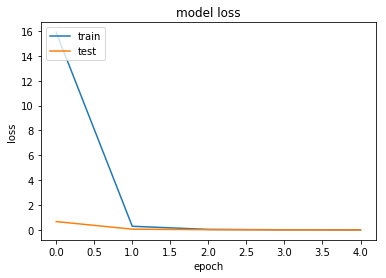

In [577]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [578]:
for i in range(2,7):
    print(model.predict(np.array([val_x[i]])), val_y[i])

[[9.91]] 10
[[10.16]] 10
[[1.01]] 1
[[9.91]] 10
[[9.91]] 10


In [490]:
np.round(val_x[0])

array([3.00, 1.00, 1.00])

In [405]:
np.round(val_x[2])

array([-0.00, 0.00, -0.00, -0.00, 0.00, -0.00, 0.00, -0.00, -0.00, 1.00,
       0.00, 0.00, -0.00, 0.00, -0.00, 1.00])